<a href="https://colab.research.google.com/github/ethvedbitdesjan/NLP/blob/main/Fine_tuning_LayoutLMv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv2ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv2 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv2 model very powerful for document understanding tasks.

LayoutLMv2 is itself an upgrade of LayoutLM. The main novelty of LayoutLMv2 is that it also pre-trains visual embeddings, whereas the original LayoutLM only adds visual embeddings during fine-tuning.

* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv2

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv2. For that, check out the notebook "Prepare CORD for LayoutLMv2".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.



## Install dependencies

First, we install the required libraries:
* Transformers (for the LayoutLMv2 model)
* Datasets (for data preprocessing)
* Seqeval (for metrics)
* Detectron2 (which LayoutLMv2 requires for its visual backbone).



In [ ]:
!rm -r transformers
!git clone -b modeling_layoutlmv2_v2 https://github.com/NielsRogge/transformers.git
!cd tranformers
!pip install -q ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 155698, done.
remote: Total 155698 (delta 0), reused 0 (delta 0), pack-reused 155698
Receiving objects: 100% (155698/155698), 127.77 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (115600/115600), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!pip install -q datasets seqeval

In [ ]:
"""
!sudo apt install tesseract-ocr
!pip install pytesseract
"""

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,821 kB/s)
debconf: unable to initia

In [ ]:
"""
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 13.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=ef89319fe35b24acdabc85fea577ce504a3245f3efc78fd772dc07e336c7e627
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/

In [ ]:
import torch
print(torch.__version__)

1.8.0+cu101


## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Resume_Info_Extraction/'

/content/gdrive/MyDrive/Resume_Info_Extraction


In [ ]:
import pandas as pd

train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [ ]:
from collections import Counter

all_labels = [item for sublist in train[3] for item in sublist] + [item for sublist in test[3] for item in sublist]
Counter(all_labels)

Counter({'Name': 17,
         'Other': 148,
         'Universities': 23,
         'Skills': 46,
         'Past_Companies': 45,
         'Email': 14,
         'Phone': 14,
         'Degrees': 26,
         'Designations': 54})

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [ ]:
all_labels = [item for sublist in train[3] for item in sublist] + [item for sublist in test[3] for item in sublist]
Counter(all_labels)

Counter({'Name': 17,
         'Other': 148,
         'Universities': 23,
         'Skills': 46,
         'Past_Companies': 45,
         'Email': 14,
         'Phone': 14,
         'Degrees': 26,
         'Designations': 54})

Now we have to save all the unique labels in a list.

In [ ]:
labels = list(set(all_labels))
print(labels)

['Universities', 'Degrees', 'Past_Companies', 'Designations', 'Phone', 'Name', 'Other', 'Skills', 'Email']


In [ ]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'Universities': 0, 'Degrees': 1, 'Past_Companies': 2, 'Designations': 3, 'Phone': 4, 'Name': 5, 'Other': 6, 'Skills': 7, 'Email': 8}
{0: 'Universities', 1: 'Degrees', 2: 'Past_Companies', 3: 'Designations', 4: 'Phone', 5: 'Name', 6: 'Other', 7: 'Skills', 8: 'Email'}


In [ ]:

from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class ResumeDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        image_file_names_temp, self.words, self.boxes, self.labels = annotations
        self.image_dir = image_dir
        self.image_file_names = [f[-10:] for f in image_file_names_temp]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [ ]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

train_dataset = ResumeDataset(annotations=train,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)
test_dataset = ResumeDataset(annotations=test,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)

Let's verify an example:

In [ ]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [ ]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
image torch.Size([3, 224, 224])


In [ ]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] nicole winowiec objective education university of colorado boulder grand valley state university license state of colorado professional teaching license expires : 3 / 2016 special education generalist state of michigan teaching license expires : 6 / 2014 special education k - 12 general education k - 5 endorsements : cognitive impairment & emotional impairment accomplishments + initiated, developed, and taught school to work program at horizon hs + nominee for the iva dean cook teacher of the year award ( through dcdt ) seedpaths llc colorado disability benefit supports program winowien @ gmail. com ( 586 ) 855 - 2445 masters in curriculum and instruction, math and science psychology / special education major director of employment disability advocate [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
train[1][0]

['Nicole Winowiec',
 'Objective',
 'Education',
 'University of Colorado Boulder',
 'Grand Valley State University',
 'License',
 'State of Colorado Professional Teaching License Expires: 3/2016  Special Education Generalist',
 'State of Michigan Teaching License Expires: 6/2014  Special Education k-12 General Education k-5  Endorsements: Cognitive Impairment & Emotional Impairment',
 'Accomplishments  + Initiated, developed, and taught School to Work program at Horizon HS  + Nominee for the Iva Dean Cook Teacher of the Year Award (through DCDT)',
 'SeedPaths LLC',
 'Colorado Disability Benefit Supports Program',
 'Winowien@gmail.com',
 '(586) 855-2445',
 'Masters in Curriculum and Instruction, Math and Science',
 'Psychology/ Special Education Major',
 'Director of Employment',
 'Disability Advocate']

In [ ]:
train[3][0]

['Name',
 'Other',
 'Other',
 'Other',
 'Universities',
 'Other',
 'Skills',
 'Skills',
 'Other',
 'Past_Companies',
 'Past_Companies',
 'Email',
 'Phone',
 'Degrees',
 'Degrees',
 'Designations',
 'Designations']

In [ ]:
[id2label[label] for label in encoding['labels'].tolist() if label != -100]

['Name',
 'Other',
 'Other',
 'Other',
 'Universities',
 'Other',
 'Skills',
 'Skills',
 'Other',
 'Past_Companies',
 'Past_Companies',
 'Email',
 'Phone',
 'Degrees',
 'Degrees',
 'Designations',
 'Designations']

In [ ]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
  print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
nicole 5
win -100
##ow -100
##iec -100
objective 6
education 6
university 6
of -100
colorado -100
boulder -100
grand 0
valley -100
state -100
university -100
license 6
state 7
of -100
colorado -100
professional -100
teaching -100
license -100
ex -100
##pire -100
##s -100
: -100
3 -100
/ -100
2016 -100
special -100


Next, we create corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [ ]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 15

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 1 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv1.norm.num_batches_tracked

Epoch: 0


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 0 steps: 2.176370859146118
Loss after 1 steps: 2.1383309364318848
Loss after 2 steps: 2.0395009517669678
Loss after 3 steps: 1.948915958404541
Loss after 4 steps: 1.9239555597305298
Loss after 5 steps: 2.144202709197998
Loss after 6 steps: 2.0299065113067627
Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 7 steps: 2.124194860458374
Loss after 8 steps: 2.0561842918395996
Loss after 9 steps: 2.0022120475769043
Loss after 10 steps: 1.8474197387695312
Loss after 11 steps: 1.8997794389724731
Loss after 12 steps: 1.741858959197998
Loss after 13 steps: 1.9652758836746216
Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 14 steps: 1.8046833276748657
Loss after 15 steps: 1.8416954278945923
Loss after 16 steps: 1.7948411703109741
Loss after 17 steps: 1.9319076538085938
Loss after 18 steps: 1.6980282068252563
Loss after 19 steps: 1.8971257209777832
Loss after 20 steps: 1.9365043640136719
Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 21 steps: 1.7156457901000977
Loss after 22 steps: 1.8767975568771362
Loss after 23 steps: 1.5536187887191772
Loss after 24 steps: 1.8535181283950806
Loss after 25 steps: 1.7930988073349
Loss after 26 steps: 1.6546928882598877
Loss after 27 steps: 1.77652108669281
Epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 28 steps: 1.7183547019958496
Loss after 29 steps: 1.5408415794372559
Loss after 30 steps: 1.5717206001281738
Loss after 31 steps: 1.561079740524292
Loss after 32 steps: 1.712243914604187
Loss after 33 steps: 1.5517675876617432
Loss after 34 steps: 1.683831810951233
Epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 35 steps: 1.6573752164840698
Loss after 36 steps: 1.6728118658065796
Loss after 37 steps: 1.4574215412139893
Loss after 38 steps: 1.4871565103530884
Loss after 39 steps: 1.4271090030670166
Loss after 40 steps: 1.3870950937271118
Loss after 41 steps: 1.5555424690246582
Epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 42 steps: 1.331436038017273
Loss after 43 steps: 1.3773469924926758
Loss after 44 steps: 1.4521338939666748
Loss after 45 steps: 1.3164156675338745
Loss after 46 steps: 1.414126992225647
Loss after 47 steps: 1.279380202293396
Loss after 48 steps: 1.3503059148788452
Epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 49 steps: 1.2683688402175903
Loss after 50 steps: 1.4091546535491943
Loss after 51 steps: 1.2606786489486694
Loss after 52 steps: 1.246789813041687
Loss after 53 steps: 1.247481346130371
Loss after 54 steps: 1.1656626462936401
Loss after 55 steps: 1.0579577684402466
Epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 56 steps: 1.1041064262390137
Loss after 57 steps: 1.2436623573303223
Loss after 58 steps: 1.20950186252594
Loss after 59 steps: 1.0840415954589844
Loss after 60 steps: 1.104228138923645
Loss after 61 steps: 1.1944966316223145
Loss after 62 steps: 1.1819270849227905
Epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 63 steps: 1.1180928945541382
Loss after 64 steps: 1.0388058423995972
Loss after 65 steps: 1.062132716178894
Loss after 66 steps: 1.1254669427871704
Loss after 67 steps: 1.060967206954956
Loss after 68 steps: 1.01431405544281
Loss after 69 steps: 1.1251137256622314
Epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 70 steps: 0.9655758142471313
Loss after 71 steps: 1.0381419658660889
Loss after 72 steps: 1.167641520500183
Loss after 73 steps: 1.0480799674987793
Loss after 74 steps: 0.9438469409942627
Loss after 75 steps: 0.9576169848442078
Loss after 76 steps: 0.9510151743888855
Epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 77 steps: 1.0055418014526367
Loss after 78 steps: 1.017214059829712
Loss after 79 steps: 1.0141104459762573
Loss after 80 steps: 0.9064751863479614
Loss after 81 steps: 1.0267287492752075
Loss after 82 steps: 1.0302767753601074
Loss after 83 steps: 1.0604884624481201
Epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 84 steps: 0.940406084060669
Loss after 85 steps: 0.9517444968223572
Loss after 86 steps: 0.8855067491531372
Loss after 87 steps: 0.8279751539230347
Loss after 88 steps: 0.9294915795326233
Loss after 89 steps: 0.9205506443977356
Loss after 90 steps: 1.010213017463684
Epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 91 steps: 1.0057389736175537
Loss after 92 steps: 0.8550999760627747
Loss after 93 steps: 0.8824133276939392
Loss after 94 steps: 0.8595402836799622
Loss after 95 steps: 0.8819603323936462
Loss after 96 steps: 0.7822228670120239
Loss after 97 steps: 0.8231394290924072
Epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]

Loss after 98 steps: 0.9580288529396057
Loss after 99 steps: 0.8010438680648804
Loss after 100 steps: 0.906262218952179
Loss after 101 steps: 0.8554644584655762
Loss after 102 steps: 0.9185659885406494
Loss after 103 steps: 0.8698849678039551
Loss after 104 steps: 0.7286083102226257


In [ ]:
loss.item()

0.7286083102226257

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [ ]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

"[CLS] ameya zambre'technical skills ‘ + java, jamseript, objective - c, c, html / css, sql ‘ + sdeveloper, eelipse, xcod, cleaess, subversion ms. computer science ‘ + elnthmsan monitor : a solution to monitor a move website for latest movies and aso to search in existing movies ‘ sing website's rest services. published on chrame wetstoe with 2500 + users. code avalale on github ( zam - ‘ brey ). avascript, html / css ) ‘ + zambrey. github. jo : a responsive personal webpage not using any existing responsive frameworks ( angular3s, html / cs8 ) 4 + salaread : a visualization tol for public sla data of georgia tech fcuty. we imported and cleaned up duby available salaries data of last 4 years to google fusion tables. utilizing that we developed an interactive visualization system using google charts plotting data agsinst various parameters to provide more isiht to the gata ( lavascript ( html / css ), google charts, google fusion tables ) 1 + volcedtext logger : an application which trn

In [ ]:
ground_truth_labels = [id2label[label] for label in encoding['labels'].squeeze().tolist() if label != -100]
print(ground_truth_labels)

['Other', 'Skills', 'Degrees', 'Other', 'Other', 'Other', 'Email', 'Phone', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Past_Companies', 'Other', 'Universities', 'Degrees', 'Universities']


In [ ]:
for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                token_type_ids=encoding['token_type_ids'], bbox=encoding['bbox'],
                image=encoding['image'])

In [ ]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(prediction_indices)

[3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 1, 

In [ ]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

['Name', 'Other', 'Past_Companies', 'Other', 'Other', 'Other', 'Email', 'Phone', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Past_Companies', 'Designations', 'Skills', 'Other', 'Skills']


In [ ]:
test = pd.read_pickle('test.pkl')

test_dataset = ResumeDataset(annotations=test,
                            image_dir='/content/gdrive/MyDrive/Resume_Info_Extraction/Images/', 
                            processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=2)

In [ ]:
len(test_dataset), len(test_dataloader)

(4, 2)

In [ ]:
import numpy as np

preds_val = None
out_label_ids = None

# put model in evaluation mode
count = 0
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [ ]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9444444444444444, 'recall': 0.9444444444444444, 'f1': 0.9444444444444444}
               precision    recall  f1-score   support

          ame       0.75      1.00      0.86         3
ast_Companies       1.00      1.00      1.00         7
       egrees       1.00      1.00      1.00         4
  esignations       0.88      1.00      0.93         7
         hone       1.00      1.00      1.00         3
        kills       1.00      0.60      0.75         5
         mail       1.00      1.00      1.00         3
  niversities       1.00      1.00      1.00         4

    micro avg       0.94      0.94      0.94        36
    macro avg       0.95      0.95      0.94        36
 weighted avg       0.95      0.94      0.94        36



In [ ]:
%cd 'Images/'

/content/gdrive/MyDrive/Resume_Info_Extraction/Images


In [ ]:
from PIL import Image, ImageDraw, ImageFont

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [ ]:
image = Image.open("image1.jpg")
image = image.convert("RGB")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt", padding = "max_length", truncation=True)
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [ ]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

outputs = model(**encoding)
print(outputs.logits.shape)

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

torch.Size([1, 512, 9])


In [ ]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

print(true_predictions)
print(true_boxes)

['Other', 'Name', 'Name', 'Other', 'Other', 'Designations', 'Designations', 'Other', 'Past_Companies', 'Designations', 'Other', 'Other', 'Other', 'Past_Companies', 'Designations', 'Other', 'Designations', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Designations', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Degrees', 'Designations', 'Degrees', 'Other', 'Other', 'Other', 'Designations', 'Other', 'Other', 'Other', 'Other', 'Other', 'Degrees', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Name', 'Name', 'Other', 'Other', 'Other', 'Designations', 'Other', 'Other', 'Other', 'Other', 'Other', 'Skills', 'Other', 'Skills', 'Other', 'Other', 'Past_Companies', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Past_Companies', 'Other', 'Other', 'Other', 'Universities', 'Past_Companies', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other'

In [ ]:
tokens = encoding.tokens()

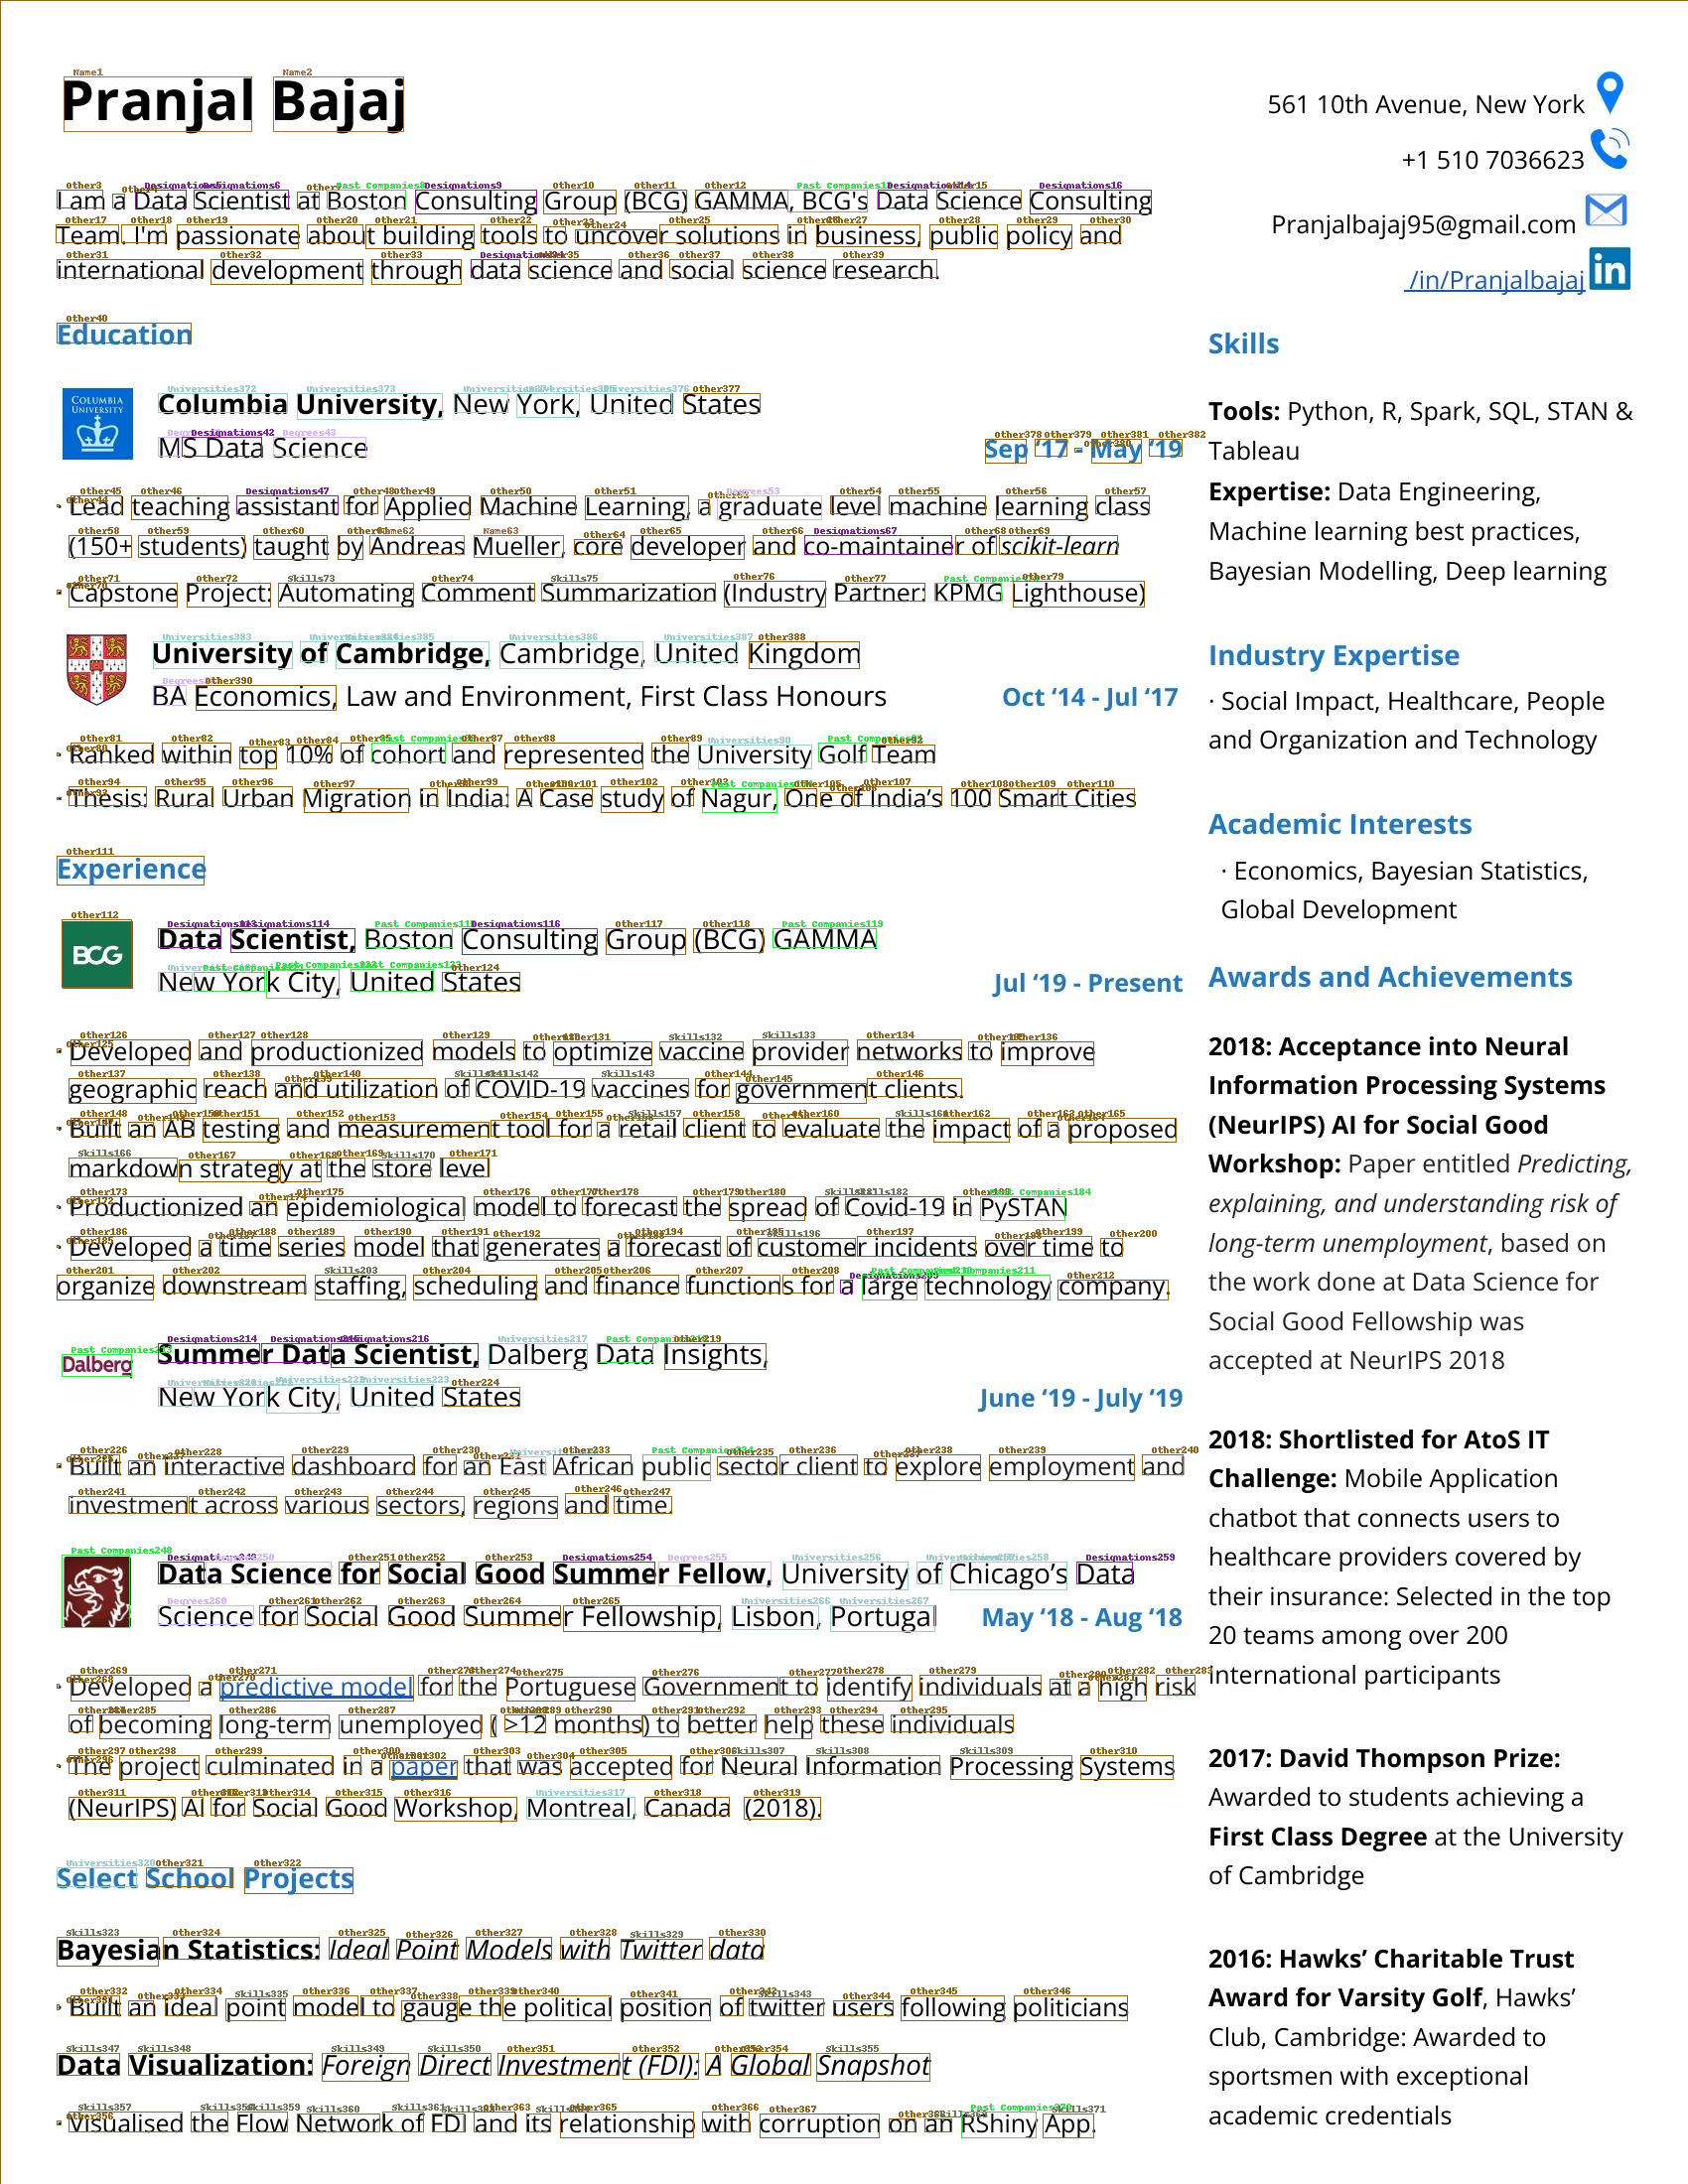

In [ ]:
import random
from PIL import ImageDraw

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

count = 0
for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label + str(count), fill=label2color[predicted_label], font=font)
    count += 1
image

In [ ]:
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
len(encoding.word_ids())

512

In [ ]:
tokens[encoding.word_ids()[214]]

'experience'

In [ ]:
encoding.words()[:10], encoding.tokens()[:10]

([None, 0, 0, 0, 1, 1, 2, 3, 4, 5],
 ['[CLS]',
  'pr',
  '##an',
  '##jal',
  'baja',
  '##j',
  'lam',
  'a',
  'data',
  'scientist'])

In [ ]:
encoding.bbox[0][:10]

tensor([[  0,   0,   0,   0],
        [ 38,  35, 149,  60],
        [ 38,  35, 149,  60],
        [ 38,  35, 149,  60],
        [162,  35, 239,  60],
        [162,  35, 239,  60],
        [ 34,  87,  61,  95],
        [ 67,  89,  74,  95],
        [ 80,  87, 110,  95],
        [115,  87, 171,  95]], device='cuda:0')

In [ ]:
for id in encoding.input_ids:
  for i, ident in enumerate(id):
    print(i, processor.tokenizer.decode(ident))

0 [CLS]
1 pr
2 ##an
3 ##jal
4 baja
5 ##j
6 lam
7 a
8 data
9 scientist
10 at
11 boston
12 consulting
13 group
14 (
15 bc
16 ##g
17 )
18 gamma
19 ,
20 bc
21 ##g
22 '
23 s
24 data
25 science
26 consulting
27 team
28 .
29 i
30 '
31 m
32 passionate
33 about
34 building
35 tools
36 to
37 uncover
38 solutions
39 in
40 business
41 ,
42 public
43 policy
44 and
45 international
46 development
47 through
48 data
49 science
50 and
51 social
52 science
53 research
54 .
55 education
56 ms
57 data
58 science
59 -
60 lead
61 teaching
62 assistant
63 for
64 applied
65 machine
66 learning
67 ,
68 a
69 graduate
70 level
71 machine
72 learning
73 class
74 (
75 150
76 +
77 students
78 )
79 taught
80 by
81 andreas
82 mueller
83 ,
84 core
85 developer
86 and
87 co
88 -
89 maintain
90 ##er
91 of
92 sci
93 ##kit
94 -
95 learn
96 -
97 caps
98 ##tone
99 project
100 :
101 auto
102 ##mat
103 ##ing
104 comment
105 sum
106 ##mar
107 ##ization
108 (
109 industry
110 partner
111 :
112 k
113 ##pm
114 ##g
115 lighthouse

In [ ]:
encoding.words()[486]

372

In [ ]:
tokens[486]

'university'